# Overview: 

This notebook is created to do tasks given in issue no #63: [Learning from misclassification](https://github.com/mozilla/PRESC/issues/63)


## Task

Develop a metric or visualization that 
- reveals something more about each misclassified point (beyond just the fact that it was misclassified) that can be used to improve the model.

---

Here I tried to use PCA to solve misclassification and improve model.
I was reading this [article](https://towardsdatascience.com/dimensionality-reduction-does-pca-really-improve-classification-outcome-6e9ba21f0a32) and found PCA can be a good fit to use to improve the model.


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, GridSearchCV,  KFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
clients_org = pd.read_csv("../../datasets/defaults.csv")
print(clients_org.shape)

(30000, 25)


### Create null values

In [3]:
clients_org['pay_0'] = clients_org['pay_0'].sample(frac=.85)
clients_org['pay_2'] = clients_org['pay_2'].sample(frac=.85)
clients_org['pay_3'] = clients_org['pay_3'].sample(frac=.85)
clients_org['pay_4'] = clients_org['pay_4'].sample(frac=.85)
clients_org['bill_amt1'] = clients_org['bill_amt1'].sample(frac=.85)
clients_org['bill_amt3'] = clients_org['bill_amt3'].sample(frac=.85)
clients_org['bill_amt5'] = clients_org['bill_amt5'].sample(frac=.85)
clients_org['pay_amt5'] = clients_org['pay_amt5'].sample(frac=.85)
clients_org['pay_amt6'] = clients_org['pay_amt6'].sample(frac=.85)

In [4]:
null_columns=clients_org.columns[clients_org.isnull().any()]

clients_org[null_columns].isnull().sum()

pay_0        4500
pay_2        4500
pay_3        4500
pay_4        4500
bill_amt1    4500
bill_amt3    4500
bill_amt5    4500
pay_amt5     4500
pay_amt6     4500
dtype: int64

In [5]:
print(clients_org.shape )
print("\n")
null_data = clients_org[clients_org.isnull().any(axis=1)]
null_data.head()

(30000, 25)




,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,defaulted
1,2,120000,2,2,2,26,-1.0,2.0,0.0,0.0,...,3272,3455.0,3261,0,1000,1000,1000,NaN,2000.0,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,...,14331,14948.0,15549,1518,1500,1000,1000,1000.0,NaN,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,...,28314,28959.0,29547,2000,2019,1200,1100,1069.0,NaN,0
4,5,50000,1,2,1,57,-1.0,0.0,-1.0,0.0,...,20940,19146.0,19131,2000,36681,10000,9000,NaN,679.0,0
5,6,50000,1,1,2,37,0.0,0.0,0.0,0.0,...,19394,19619.0,20024,2500,1815,657,1000,1000.0,800.0,0


In [6]:
#check for duplicate rows and columns
clients_org1 = clients_org.duplicated()
print(clients_org[clients_org1]) 

#Removing duplicates 
clients_org = clients_org[clients_org.duplicated() == False]

Empty DataFrame
Columns: [id, limit_bal, sex, education, marriage, age, pay_0, pay_2, pay_3, pay_4, pay_5, pay_6, bill_amt1, bill_amt2, bill_amt3, bill_amt4, bill_amt5, bill_amt6, pay_amt1, pay_amt2, pay_amt3, pay_amt4, pay_amt5, pay_amt6, defaulted]
Index: []

[0 rows x 25 columns]


There are no duplicates record found


In [7]:
clients_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         30000 non-null  int64  
 1   limit_bal  30000 non-null  int64  
 2   sex        30000 non-null  int64  
 3   education  30000 non-null  int64  
 4   marriage   30000 non-null  int64  
 5   age        30000 non-null  int64  
 6   pay_0      25500 non-null  float64
 7   pay_2      25500 non-null  float64
 8   pay_3      25500 non-null  float64
 9   pay_4      25500 non-null  float64
 10  pay_5      30000 non-null  int64  
 11  pay_6      30000 non-null  int64  
 12  bill_amt1  25500 non-null  float64
 13  bill_amt2  30000 non-null  int64  
 14  bill_amt3  25500 non-null  float64
 15  bill_amt4  30000 non-null  int64  
 16  bill_amt5  25500 non-null  float64
 17  bill_amt6  30000 non-null  int64  
 18  pay_amt1   30000 non-null  int64  
 19  pay_amt2   30000 non-null  int64  
 20  pay_am

In [8]:
#renaming the columns "pay_0" to "pay_1"
clients_mod = clients_org.rename(columns={'pay_0': 'pay_1'})

#renaming the columns "default_payment_next_month" to "is_default"
clients_mod = clients_mod.rename(columns={'defaulted': 'is_default'})

In [9]:
# Each record in a row is independent of other records. 
# Hence some missing values do not affect in predicting for other rows. We will be dropping those rows which have null values.

clients_mod = clients_mod.dropna()
clients_mod.shape

(6915, 25)

In [10]:
print(clients_mod['is_default'].value_counts())
clients_mod.drop(['id'], inplace=True, axis =1)

0    5372
1    1543
Name: is_default, dtype: int64


In [11]:
cl_cor = clients_mod.corr()

# Heatmap

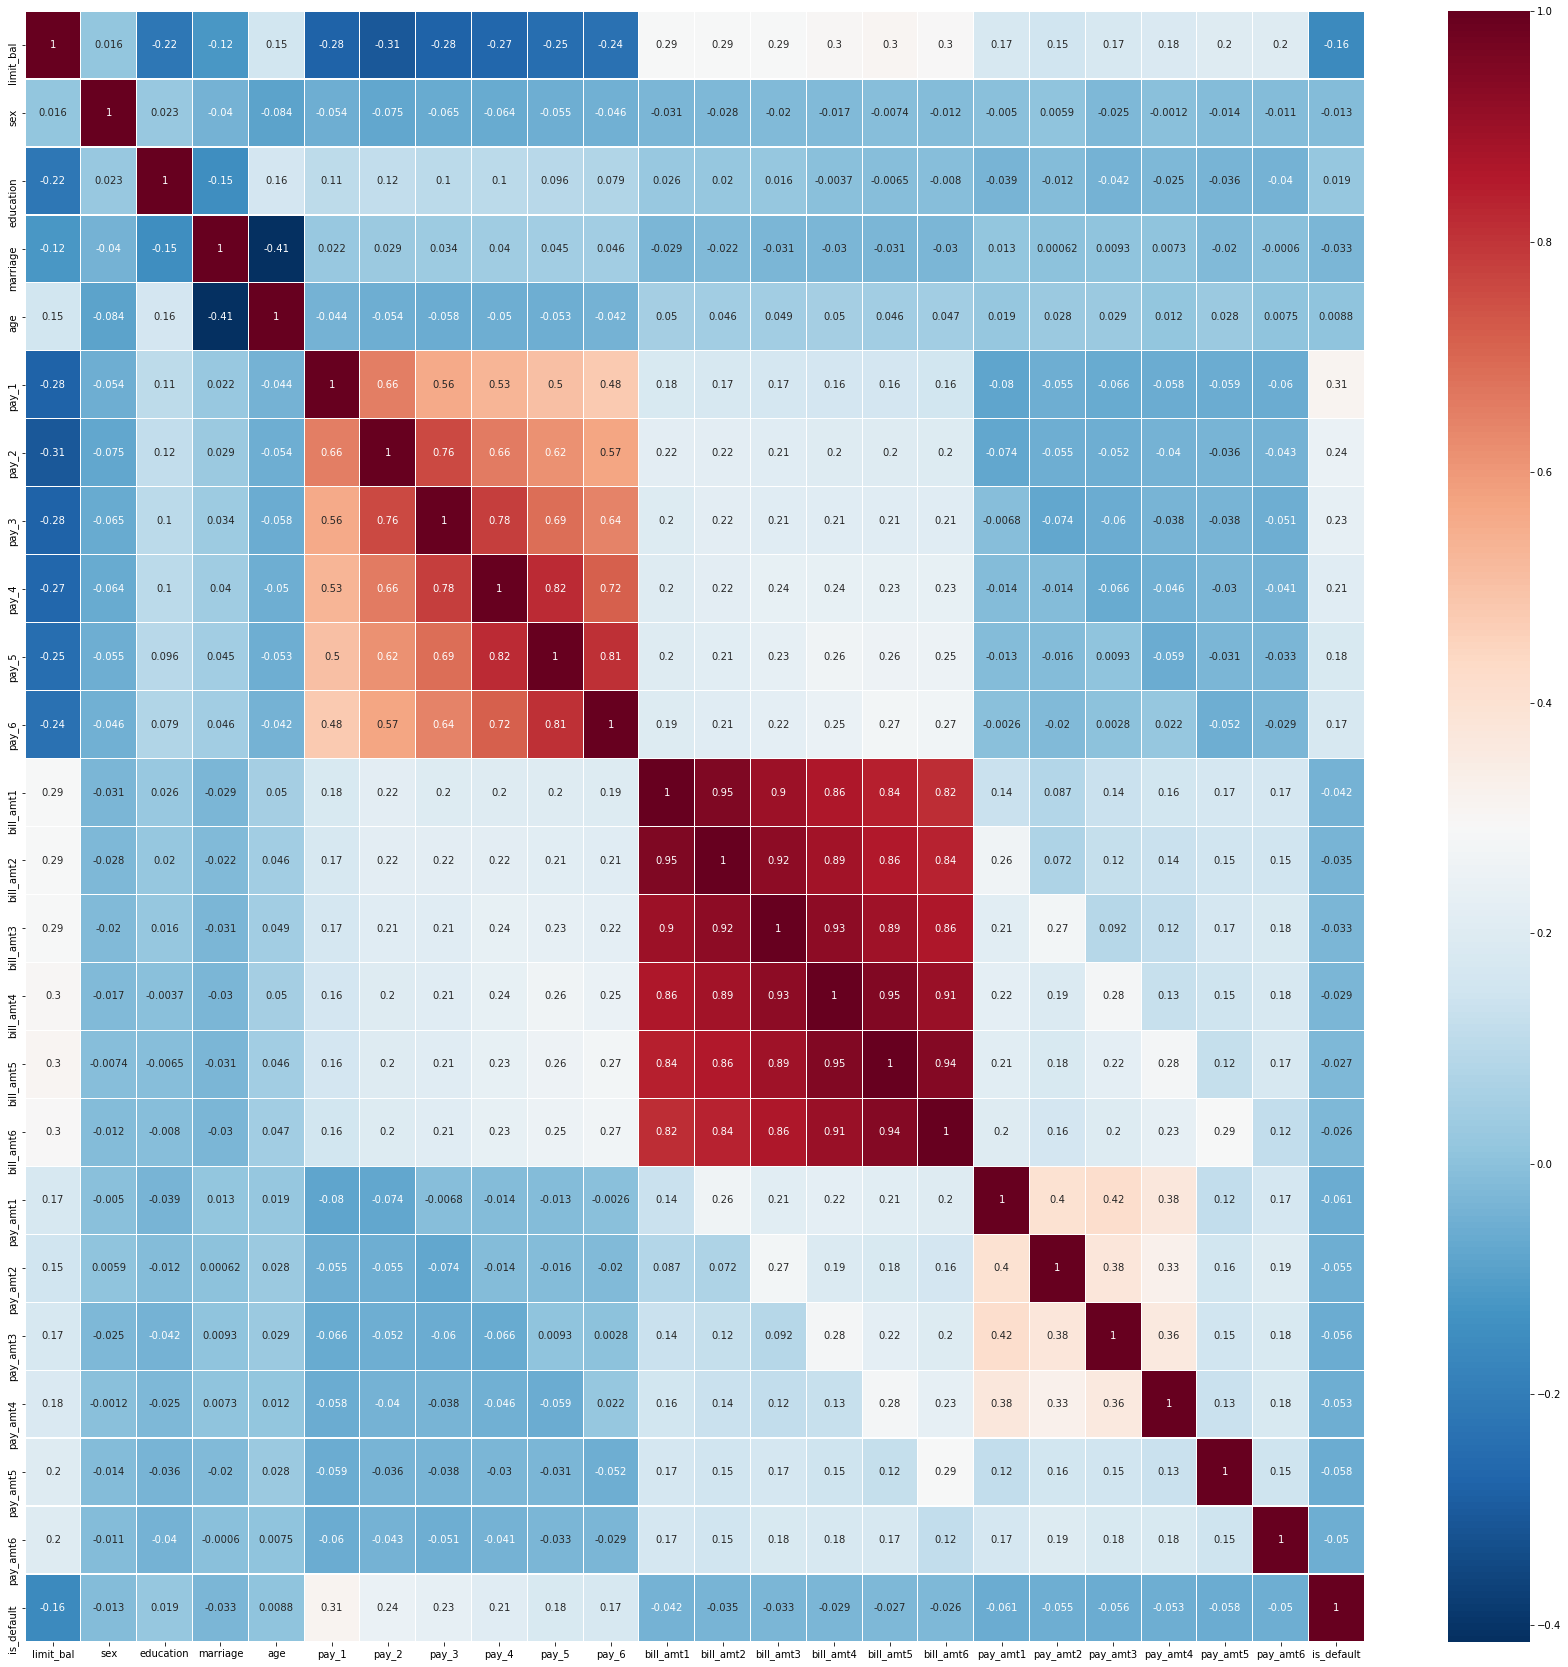

In [12]:
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(cl_cor,annot=True,cmap='RdBu_r',linewidths=0.15, ax=ax)

In [13]:
corr_matrix = clients_mod.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
cl_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [14]:
cl_drop

['bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']

In [15]:
clients_mod = clients_mod.drop(cl_drop,axis=1)
print(clients_mod.shape)

(6915, 19)


## Checking Correlation after dropping those variables

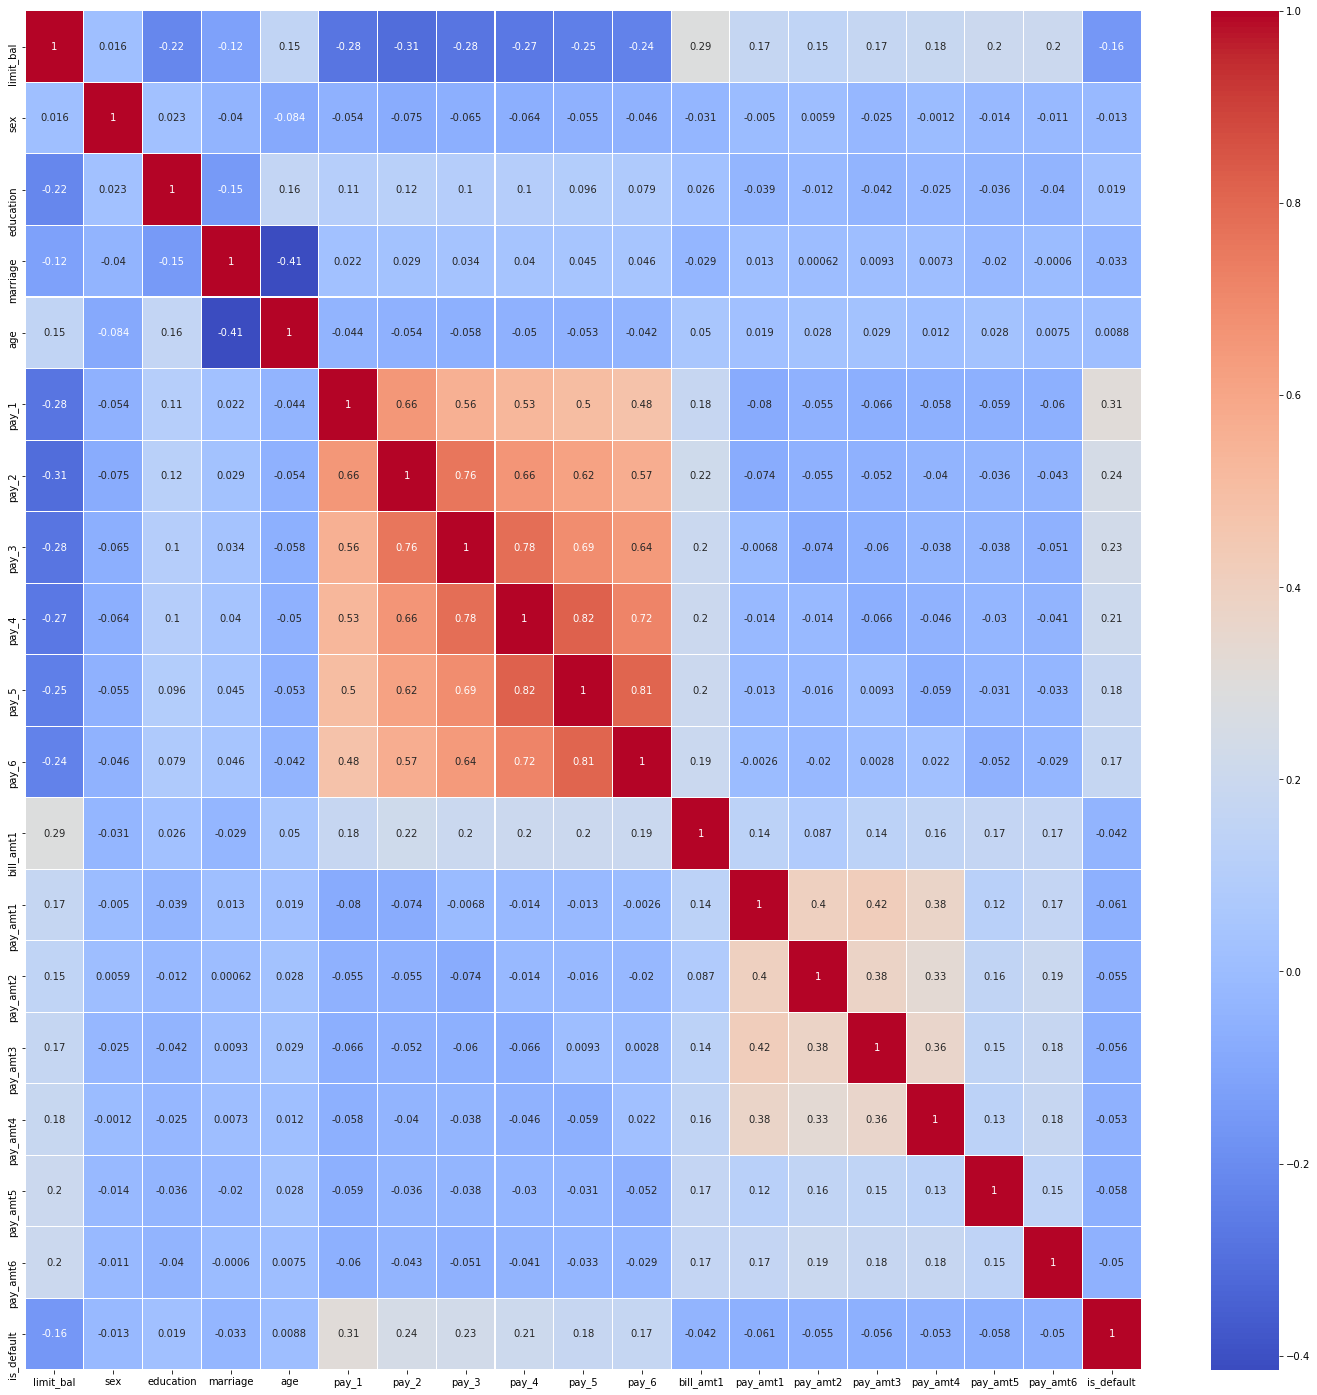

In [16]:
clients_mod1 = clients_mod.corr()
fig, ax = plt.subplots(figsize=(25,25)) 
sns.heatmap(clients_mod1,annot=True,cmap='coolwarm',linewidths=0.1, ax=ax)

## Removing outliers with 3sigma rule

In [17]:
clients_mod = clients_mod[(np.abs(stats.zscore(clients_mod)) < 3).all(axis=1)]
clients_mod.shape

(6145, 19)

# Data cleaning

## Marriage

- Only two marital statuses are known (1 and 2). If the marital status is 0 or 3, we group them as unknown. 
- Replacing any marital status with 3 as its value is assigned value 0. 
- Marital status (1 = married; 2 = single; 3 = others). 

In [18]:
print(clients_mod['marriage'].value_counts())

#The record for 0 is not defined, hence we replace that to the 3rd category under marriage
clients_mod['marriage'] = np.where((clients_mod.marriage == 0),3,clients_mod.marriage)
clients_mod['marriage'].value_counts()

2    3315
1    2754
3      66
0      10
Name: marriage, dtype: int64


2    3315
1    2754
3      76
Name: marriage, dtype: int64

## Education
- Education can have a value 0 which was not known before.
- Grouping 0,4,5,6 as unknowns.
- Replacing any education greater than or equal to four with 0



In [19]:
clients_mod.loc[clients_mod.education >= 4, 'education'] = 4
clients_mod['education'] = np.where((clients_mod.education == 0),4,clients_mod.education)

## Handling categorical variables

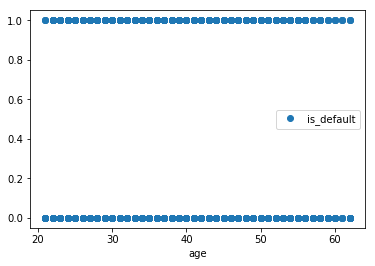

In [20]:
clients_mod.plot(x='age', y='is_default', style='o')

As we are predicting if a person is credible for next month, age doesnt make much of an impact.
The change in age in a month is a very trivial change to be considered.
Since we have many values for age and creating group for these ages will not help our model, we decide to drop this 






In [21]:
clients_mod.drop(['age'], inplace=True, axis =1)

clients_mod.shape

(6145, 18)

In [22]:
clients_mod = pd.concat([clients_mod,pd.get_dummies(clients_mod['marriage'], prefix='marriage',dummy_na=True)],axis=1).drop(['marriage'],axis=1)
clients_mod.drop('marriage_nan', axis=1, inplace=True)
clients_mod = clients_mod.rename(columns={"marriage_1.0": "marriage_1","marriage_2.0": "marriage_2","marriage_3.0": "marriage_3"})

In [23]:
clients_mod['education'].unique()

array([2, 1, 3, 4], dtype=int64)

In [24]:
clients_mod = pd.concat([clients_mod,pd.get_dummies(clients_mod['education'], prefix='education',dummy_na=True)],axis=1).drop(['education'],axis=1)
clients_mod.drop('education_nan', axis=1, inplace=True)
clients_mod = clients_mod.rename(columns={"education_0.0": "education_0","education_1.0": "education_1","education_2.0": "education_2","education_3.0": "education_3","education_4.0": "education_4"})

In [25]:
clients_mod.head(1)

,limit_bal,sex,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,pay_amt1,...,pay_amt5,pay_amt6,is_default,marriage_1,marriage_2,marriage_3,education_1,education_2,education_3,education_4
0,20000,2,2.0,2.0,-1.0,-1.0,-2,-2,3913.0,0,...,0.0,0.0,1,1,0,0,0,1,0,0


## Feature selection using VARIANCE INFLATION FACTOR

In [26]:
clients = add_constant(clients_mod)
pd.Series([variance_inflation_factor(clients_mod.values, i) 
               for i in range(clients_mod.shape[1])], index=clients_mod.columns)

c:\users\humayra\miniconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


limit_bal      1.440026
sex            1.010537
pay_1          1.858722
pay_2          2.932851
pay_3          3.379590
pay_4          3.894776
pay_5          4.071035
pay_6          2.852710
bill_amt1      1.376563
pay_amt1       1.396652
pay_amt2       1.250187
pay_amt3       1.319096
pay_amt4       1.308321
pay_amt5       1.314778
pay_amt6       1.288857
is_default     1.150699
marriage_1          inf
marriage_2          inf
marriage_3          inf
education_1         inf
education_2         inf
education_3         inf
education_4         inf
dtype: float64

In [27]:
clients_1 = clients.drop(['marriage_1','marriage_2','marriage_3','education_1','education_2','education_3','education_4'],axis=1)

In [28]:
#Repeating VIF process
clients = add_constant(clients_1)
pd.Series([variance_inflation_factor(clients.values, i) 
               for i in range(clients.shape[1])], index=clients.columns)

const         14.626072
limit_bal      1.346297
sex            1.006368
pay_1          1.856431
pay_2          2.928265
pay_3          3.378268
pay_4          3.891506
pay_5          4.062304
pay_6          2.848096
bill_amt1      1.373434
pay_amt1       1.395598
pay_amt2       1.249920
pay_amt3       1.315573
pay_amt4       1.307436
pay_amt5       1.314436
pay_amt6       1.287905
is_default     1.146063
dtype: float64

In [29]:
clients = clients.drop(['const'],axis=1)

In [30]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6145 entries, 0 to 29990
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   limit_bal   6145 non-null   int64  
 1   sex         6145 non-null   int64  
 2   pay_1       6145 non-null   float64
 3   pay_2       6145 non-null   float64
 4   pay_3       6145 non-null   float64
 5   pay_4       6145 non-null   float64
 6   pay_5       6145 non-null   int64  
 7   pay_6       6145 non-null   int64  
 8   bill_amt1   6145 non-null   float64
 9   pay_amt1    6145 non-null   int64  
 10  pay_amt2    6145 non-null   int64  
 11  pay_amt3    6145 non-null   int64  
 12  pay_amt4    6145 non-null   int64  
 13  pay_amt5    6145 non-null   float64
 14  pay_amt6    6145 non-null   float64
 15  is_default  6145 non-null   int64  
dtypes: float64(7), int64(9)
memory usage: 816.1 KB


## Creating numpy arrays for features and target

In [31]:
X = clients.drop('is_default',axis=1).values
y = clients['is_default'].values

In [32]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
X_train_org

array([[ 2.300e+05,  2.000e+00, -1.000e+00, ...,  7.032e+03,  5.030e+03,
         8.007e+03],
       [ 1.200e+05,  2.000e+00,  0.000e+00, ...,  0.000e+00,  3.090e+04,
         3.090e+04],
       [ 2.000e+05,  2.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       ...,
       [ 2.000e+05,  2.000e+00, -2.000e+00, ...,  2.640e+02,  2.640e+02,
         0.000e+00],
       [ 5.000e+04,  2.000e+00,  0.000e+00, ...,  1.000e+03,  1.000e+03,
         2.000e+03],
       [ 3.600e+05,  2.000e+00, -1.000e+00, ...,  6.610e+02,  6.580e+02,
         5.320e+02]])

In [33]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

In [34]:
print(X_train, X_test)

[[0.40740741 1.         0.2        ... 0.14064    0.10418393 0.1426332 ]
 [0.2037037  1.         0.4        ... 0.         0.64001657 0.5504391 ]
 [0.35185185 1.         0.4        ... 0.         0.         0.        ]
 ...
 [0.35185185 1.         0.         ... 0.00528    0.0054681  0.        ]
 [0.07407407 1.         0.4        ... 0.02       0.02071251 0.03562713]
 [0.64814815 1.         0.2        ... 0.01322    0.01362883 0.00947682]] [[0.35185185 0.         0.         ... 0.04732    0.06103977 0.0203609 ]
 [0.2962963  0.         0.2        ... 0.00232    0.13676471 0.07125425]
 [0.03703704 1.         0.6        ... 0.02082    0.02357084 0.01660224]
 ...
 [0.42592593 0.         0.4        ... 0.07642    0.0817937  0.07082673]
 [0.35185185 1.         0.         ... 0.084      0.15144988 0.38726686]
 [0.01851852 0.         0.8        ... 0.         0.02278376 0.        ]]


# Logistic regression

In [35]:
log_clf = LogisticRegression()
penalty = ['l1', 'l2']
C = [0.001,0.01,0.1,1,10,100]
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(log_clf,parameters, cv=6, return_train_score=True)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=0)
grid_search.fit(X_train1, y_train1)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [36]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 0.1, 'penalty': 'l1'}
Best cross-validation score: 0.81


In [37]:
log_l1 = LogisticRegression(penalty = 'l1', C = 1)
log_l1.fit(X_train, y_train)
#log_l2.fit(X_train, y_train)
print(log_l1.score(X_train, y_train))
#test_score_l1.append(log_l1.score(X_test, y_test))
print(log_l1.score(X_test, y_test))

0.8073637103336045
0.8104149715215623


In [38]:
log_clf = LogisticRegression(C=1)
log_clf.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
log_l1 = LogisticRegression(penalty = 'l1', C = 1)
kfold = KFold(n_splits=6)
print("Cross-validation scores:\n{}".format(cross_val_score(log_l1 , X_train, y_train, cv=kfold)))
scores = cross_val_score(log_l1 , X_train, y_train, cv=kfold)
print(np.mean(scores))

Cross-validation scores:
[0.81463415 0.79146341 0.7960928  0.81684982 0.8009768  0.81684982]
0.8059409650873065


In [40]:
log_l1 = LogisticRegression(penalty = 'l1', C = 1)
log_l1.fit(X_train, y_train)
ypred = log_l1.predict(X_test)
ft = f1_score(ypred,y_test)
cm = confusion_matrix(ypred,y_test)
print(ft)
print(cm)

0.3719676549865229
[[927 195]
 [ 38  69]]


#### Logistic Regression Summary 

Train score: 0.8111

Test score: 0.8234

Cross validation score:0.81

Best parameters: c: 1 

Best parameters: penalty: l1 

F1 Score : 0.4043

### KNN Classifier

In [41]:
train_score_array = []
test_score_array = []

for k in range(1,20):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    train_score_array.append(knn.score(X_train, y_train))
    test_score_array.append(knn.score(X_test, y_test))

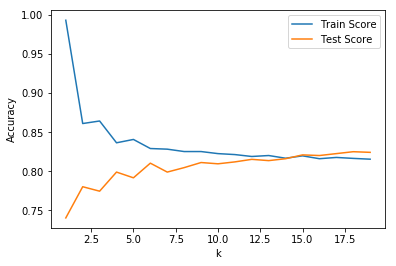

In [42]:
x_axis = range(1,20)
%matplotlib inline
plt.plot(x_axis, train_score_array, label = 'Train Score')
plt.plot(x_axis, test_score_array, label = 'Test Score')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()

In [43]:
knn = KNeighborsClassifier(13)
knn.fit(X_train, y_train)
print('Train score: {:.4f}'.format(knn.score(X_train, y_train)))
print('Test score: {:.4f}'.format(knn.score(X_test, y_test)))

Train score: 0.8202
Test score: 0.8137


In [44]:
kfold = KFold(n_splits=13)
print("Cross-validation scores:\n{}".format(cross_val_score(knn , X_train, y_train, cv=kfold)))
scores = cross_val_score(knn , X_train, y_train, cv=kfold)
print(np.mean(scores))

Cross-validation scores:
[0.823219   0.80211082 0.80687831 0.76719577 0.81216931 0.78835979
 0.78835979 0.78306878 0.83597884 0.77777778 0.81481481 0.83597884
 0.79100529]
0.8020705474531332


In [45]:
knn = KNeighborsClassifier(20)
knn.fit(X_train, y_train)
ypred = knn.predict(X_test)
cm = confusion_matrix(ypred,y_test)
f = f1_score(ypred,y_test)
print(cm)
print(f)

[[923 173]
 [ 42  91]]
0.4584382871536524


#### KNN Classification Summary

Train score: 0.8185

Test score: 0.8154

Cross validation score:0.8032

Best parameters: n_neighbors: 13

F1 Score = 0.4278

# Decision Tree 

In [46]:
for i in range(1,10):
    dtree_clf = DecisionTreeClassifier(max_depth=i, random_state=0)
    dtree_clf.fit(X_train, y_train)
    train= dtree_clf.score(X_train, y_train)
    test = dtree_clf.score(X_test, y_test)
    print("Accuracy on training set: {:.3f}".format(dtree_clf.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(dtree_clf.score(X_test, y_test)))

Accuracy on training set: 0.816
Accuracy on test set: 0.828
Accuracy on training set: 0.817
Accuracy on test set: 0.830
Accuracy on training set: 0.818
Accuracy on test set: 0.831
Accuracy on training set: 0.820
Accuracy on test set: 0.826
Accuracy on training set: 0.824
Accuracy on test set: 0.826
Accuracy on training set: 0.832
Accuracy on test set: 0.820
Accuracy on training set: 0.843
Accuracy on test set: 0.814
Accuracy on training set: 0.854
Accuracy on test set: 0.810
Accuracy on training set: 0.868
Accuracy on test set: 0.814


In [47]:
dtree_clf = DecisionTreeClassifier(random_state=0)
parameters = { 'max_depth' : [1,2,3,4,5,6,7,8,9,10]}

In [48]:
grid_search = GridSearchCV(dtree_clf,parameters, cv=6, return_train_score=True)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=0)
grid_search.fit(X_train1, y_train1)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [49]:
dtree = DecisionTreeClassifier(random_state=0)

dtree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(dtree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dtree.score(X_test, y_test)))

Accuracy on training set: 0.994
Accuracy on test set: 0.723


In [50]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'max_depth': 1}
Best cross-validation score: 0.82


In [51]:
dtree = DecisionTreeClassifier(max_depth=2, random_state=0)
dtree.fit(X_train, y_train)
ypred = dtree.predict(X_test)
cm = confusion_matrix(ypred,y_test)
ft = f1_score(ypred,y_test)
print(cm)
print(ft)

[[931 175]
 [ 34  89]]
0.45994832041343664


Using Grid search, we find the max depth as 2 in decision tree model


### Decision tree summary

Train score: 0.995

Test score: 0.737

Cross validation score:0.82

F1 Score :0.443

# Gaussian Naive Bayes


In [52]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, random_state = 0)
scaler = MinMaxScaler()
scaler.fit(X_train_org)
X_train = scaler.transform(X_train_org)
X_test = scaler.transform(X_test_org)

In [53]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [54]:
print(gnb_clf.score(X_train,y_train))
print(gnb_clf.score(X_test,y_test))

0.7554253472222222
0.7501626545217958


# Sklearn Classification Voting: Model Ensemble

Like the system that enabled multiple trees to predict together, this system brings together models of all types. A broader implementation. We can train your model using diverse algorithms and then ensemble them to predict the final output. For example, if we use a Random Forest Classifier, SVM Classifier, Linear Regression etc.; models are pitted against each other and selected upon best performance by voting using the `VotingClassifier` Class from sklearn.ensemble.

- **Hard Voting:** is where a model is selected from an ensemble to make the final prediction by a simple majority vote for accuracy. Plurality voting over the classes.
- **Soft Voting:** Selects classed based off aggregated probabilities over the models. Requires model with probabilistic capabilities, while hard votes may polarize a small difference between models. It can only be done when all classifiers can calculate probabilities for the outcomes. Soft voting arrives at the best result by averaging out the probabilities calculated by individual algorithms.

### Soft Voting

In [55]:
#Soft voting using logistic regression and Gaussian naive bayes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

In [56]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf),('Gaussian',gnb_clf)], voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('Gaussian', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [57]:
for clf in (log_clf,gnb_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7851912123677787
GaussianNB 0.5093572009764036
VotingClassifier 0.6167615947925142


### Hard Voting

In [58]:
# Hard voting using knn classifier and Gaussian naive bayes

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

In [59]:
voting_clf = VotingClassifier(estimators=[('knn', knn),('Gaussian',gnb_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')), ('Gaussian', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [60]:
for clf in (knn,gnb_clf,voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


KNeighborsClassifier 0.7819365337672904
GaussianNB 0.5093572009764036
VotingClassifier 0.7803091944670464


# PCA

PCA stands for Principal Component Analysis and is an established technique in machine learning. PCA is one of the easiest, most intuitive, and most frequently used methods for dimensionality reduction, projecting data onto its orthogonal feature subspace. It works by analyzing data that contains multiple variables. It looks for correlations among the variables and determines the combination of values that best captures differences in outcomes. These combined feature values are used to create a more compact feature space called the principal components.

PCA is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning.
High dimensionality means that the dataset has a large number of features. The primary problem associated with high-dimensionality in the machine learning field is model overfitting, which reduces the ability to generalize beyond the examples in the training set.

The ability to generalize correctly becomes exponentially harder as the dimensionality of the training dataset grows, as the training set covers a dwindling fraction of the input space. Models also become more efficient as the reduced feature set boosts learning rates and diminishes computation costs by removing redundant features.
PCA can also be used to filter noisy datasets, such as image compression. The first principal component expresses the most amount of variance. Each additional component expresses less variance and more noise, so representing the data with a smaller subset of principal components preserves the signal and discards the noise.

## Assumptions

PCA is based on the Pearson correlation coefficient framework and inherits similar assumptions.

- **Sample size:** Minimum of 150 observations and ideally a 5:1 ratio of observation to features (Pallant, 2010)
- **Correlations:** The feature set is correlated, so the reduced feature set effectively represents the original data space.
- **Linearity:** All variables exhibit a constant multivariate normal relationship, and principal components are a linear combination of the original features.
- **Outliers:** No significant outliers in the data as these can have a disproportionate influence on the results.
- **Large variance implies more structure:** high variance axes are treated as principal components, while low variance axes are treated as noise and discarded.

In [61]:
clients_pca = clients

In [62]:
X = clients_pca.drop('is_default',axis=1).values
y = clients_pca['is_default'].values

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.2)

In [64]:
#create model
pca = PCA(n_components=0.95,random_state = 0)

#train pca model
pca.fit(X_train)

#transforming X_train and X_test
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [65]:
X_train_reduced

array([[  68876.18191088,  -45373.39575469],
       [ -33056.7649083 ,   56284.0657622 ],
       [  41680.80990016,    -795.42480581],
       ...,
       [  37598.93237595,  -47468.0429894 ],
       [-110902.86807426,  -24756.5260144 ],
       [ 197439.87175233,  -56165.65387927]])

In [66]:
pca.n_components_

2

In [67]:
pca.explained_variance_

array([1.44995936e+10, 3.03103961e+09])

In [68]:
pca.explained_variance_ratio_

array([0.81832151, 0.17106444])

In [69]:
scaler = MinMaxScaler()
X_train_pca = scaler.fit_transform(X_train_reduced)
X_test_pca = scaler.transform(X_test_reduced)

### KNN (after applying PCA)

In [70]:
train_score_array = []
test_score_array = []

for k in range(1,20):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train_pca, y_train)
    train_score_array.append(knn.score(X_train_pca, y_train))
    test_score_array.append(knn.score(X_test_pca, y_test))

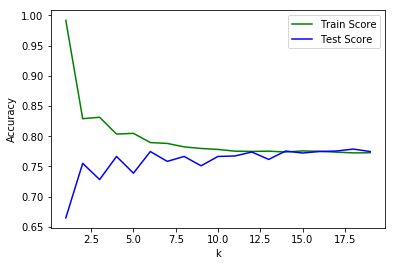

In [71]:
x_axis = range(1,20)

plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()

In [72]:
knn = KNeighborsClassifier(8)
knn.fit(X_train_pca, y_train)
print(knn.score(X_train_pca, y_train))
print(knn.score(X_test_pca, y_test))

0.7823433685923515
0.7664768104149715


In [73]:
kfold = KFold(n_splits=8)
print("Cross-validation scores:\n{}".format(cross_val_score(knn , X_train_reduced, y_train, cv=kfold)))
scores = cross_val_score(knn , X_train_reduced, y_train, cv=kfold)
print(np.mean(scores))

Cross-validation scores:
[0.74796748 0.73170732 0.75447154 0.74634146 0.77361564 0.78338762
 0.76384365 0.74267101]
0.7555007150234369


In [74]:
knn = KNeighborsClassifier(2)
knn.fit(X_train_pca, y_train)
ypred = knn.predict(X_test_pca)
cm = confusion_matrix(ypred,y_test)
f = f1_score(ypred,y_test)
print(cm)
print(f)

[[907 243]
 [ 58  21]]
0.12244897959183675


##### KNN Classification Summary - Before PCA

Train score: 0.8185

Test score: 0.8154

Cross validation score:0.8032

Best parameters: n_neighbors: 13

F1 Score = 0.4278

##### KNN Classification Summary - After PCA

Train score: 0.7921

Test score: 0.7732

Cross validation score:0.7605

Best parameters: n_neighbors: 8

F1 Score = 0.1230

### Logistic Regression

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
#create model
pca = PCA(n_components=0.95,random_state = 0)

#train pca model
pca.fit(X_train)

#transforming X_train and X_test
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [76]:
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_score_l1 = []
train_score_l2 = []
test_score_l1 = []
test_score_l2 = []

for c in c_range:
    log_l1 = LogisticRegression(penalty = 'l1', C = c)
    log_l2 = LogisticRegression(penalty = 'l2', C = c)
    log_l1.fit(X_train_reduced, y_train)
    log_l2.fit(X_train_reduced, y_train)
    train_score_l1.append(log_l1.score(X_train_reduced, y_train))
    train_score_l2.append(log_l2.score(X_train_reduced, y_train))
    test_score_l1.append(log_l1.score(X_test_reduced, y_test))
    test_score_l2.append(log_l2.score(X_test_reduced, y_test))

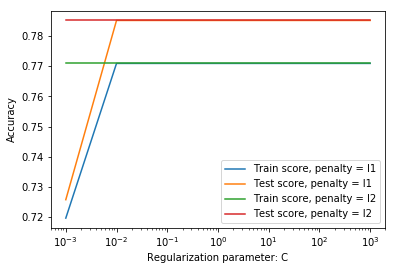

In [77]:
plt.plot(c_range, train_score_l1, label = 'Train score, penalty = l1')
plt.plot(c_range, test_score_l1, label = 'Test score, penalty = l1')
plt.plot(c_range, train_score_l2, label = 'Train score, penalty = l2')
plt.plot(c_range, test_score_l2, label = 'Test score, penalty = l2')
plt.legend()
plt.xlabel('Regularization parameter: C')
plt.ylabel('Accuracy')
plt.xscale('log')

In [78]:
model = LogisticRegression()
penalty = ['l1', 'l2']
C = [0.001,0.01,0.1,1,10,100]
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(model,parameters, cv=6, return_train_score=True)
grid_search.fit(X_train_reduced, y_train)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [79]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 0.01, 'penalty': 'l1'}
Best cross-validation score: 0.77


In [80]:
log_l2 = LogisticRegression(penalty = 'l2', C = 100)
#log_l1.fit(X_train, y_train)
log_l2.fit(X_train_reduced, y_train)
print(log_l2.score(X_train_reduced, y_train))
#test_score_l1.append(log_l1.score(X_test, y_test))
print(log_l2.score(X_test_reduced, y_test))

0.7709519934906428
0.7851912123677787


In [81]:
log_l1 = LogisticRegression(penalty = 'l1', C = 0.01)
kfold = KFold(n_splits=2)
print("Cross-validation scores:\n{}".format(cross_val_score(log_l2 , X_train_reduced, y_train, cv=kfold)))
scores = cross_val_score(log_l2 , X_train_reduced, y_train, cv=kfold)
print(np.mean(scores))

Cross-validation scores:
[0.76444264 0.77746135]
0.7709519934906428


In [82]:
log_l2 = LogisticRegression(penalty = 'l1', C = 0.01)
log_l2.fit(X_train_reduced, y_train)
ypred = log_l2.predict(X_test_reduced)
ft = f1_score(ypred,y_test)
cm = confusion_matrix(ypred,y_test)
print(ft)
print(cm)

0.0
[[965 264]
 [  0   0]]


c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


##### Logistic Regression Summary - Before PCA

Train score: 0.8111

Test score: 0.8234

Cross validation score:0.81

Best parameters: c: 1 

Best parameters: penalty: l1 

F1 Score : 0.4043

##### Logistic Regression Summary - After PCA

Train score: 0.77

Test score: 0.8

Cross validation score:0.7787

Best parameters: c: 0.01 

Best parameters: penalty: l1 

F1 Score : 0.

### Decision Tree

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
#create model
pca = PCA(n_components=0.95,random_state = 0)

#train pca model
pca.fit(X_train)

#transforming X_train and X_test
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [84]:
param_grid = {
    'max_depth' : [1,2,3,4,5,6,7,8,9,10]
}

In [85]:
dtree_clf = GridSearchCV(DecisionTreeClassifier(random_state=0),param_grid, cv=6, return_train_score=True)
dtree_clf.fit(X_train_reduced, y_train)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [86]:
print("Best parameters: {}".format(dtree_clf.best_params_))
print("Best cross-validation score: {:.2f}".format(dtree_clf.best_score_))

Best parameters: {'max_depth': 1}
Best cross-validation score: 0.77


In [87]:
dtree = DecisionTreeClassifier(max_depth=1, random_state=0)
dtree.fit(X_train_reduced, y_train)

print("Accuracy on training set: {:.3f}".format(dtree.score(X_train_reduced, y_train)))
print("Accuracy on test set: {:.3f}".format(dtree.score(X_test_reduced, y_test)))

Accuracy on training set: 0.771
Accuracy on test set: 0.785


In [88]:
dtree = DecisionTreeClassifier(max_depth=1, random_state=0)
kfold = KFold(n_splits=6)
print("Cross-validation scores:\n{}".format(cross_val_score(dtree , X_train_reduced, y_train, cv=kfold)))
scores = cross_val_score(dtree , X_train, y_train, cv=kfold)
print(np.mean(scores))

Cross-validation scores:
[0.75853659 0.76707317 0.76800977 0.78632479 0.78388278 0.76190476]
0.8157027705808192


In [89]:
dtree = DecisionTreeClassifier(max_depth=1, random_state=0)
dtree.fit(X_train_reduced, y_train)
ypred = dtree.predict(X_test_reduced)
cm = confusion_matrix(ypred,y_test)
ft = f1_score(ypred,y_test)
print(cm)
print(ft)

[[965 264]
 [  0   0]]
0.0


c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


##### Decision tree summary - Before PCA

Train score: 0.824

Test score: 0.812

Cross validation score:0.79

F1 Score :0.451

##### Decision tree summary - After PCA

Train score: 0.779

Test score: 0.800

Cross validation score:0.817

F1 Score :0.0

--- 

Here I am facing a problem. 
If we look at the accuracy, we can see our accuracy didnt improve much after using PCA, it got worse. It was supposed to get improved.  
I followed this [repo](https://github.com/lambdaofgod/stackexchange/blob/master/cross%20validated/Digits%20PCA.ipynb), but it didnt solve my problem. Still working to figure out what should I do to improve my accuracy. 